# GradCAM Tutorial for Image Classification

Run all cells in order.

---

## What is GradCAM?

**GradCAM** produces visual explanations for CNN predictions by highlighting important regions in the input image.

### Key Concepts:

1. **Gradient-based**: Uses gradients flowing into convolutional layers
2. **Class-discriminative**: Specific to the target class
3. **Fast**: Only requires one forward and one backward pass
4. **Architecture-agnostic**: Works with any CNN without modification

### How GradCAM Works:

```
1. Forward pass: Get feature maps from last convolutional layer
2. Compute gradient of target class score w.r.t. feature maps
3. Global average pooling of gradients → importance weights
4. Weighted combination of feature maps
5. Apply ReLU (keep only positive influences)
6. Upsample to original image size
```

### Mathematical Formulation:

For target class $c$ and feature map $A^k$ at spatial location $(i,j)$:

**Step 1**: Compute importance weights via global average pooling of gradients:

$$\alpha_k^c = \frac{1}{Z} \sum_i \sum_j \frac{\partial y^c}{\partial A_{ij}^k}$$

**Step 2**: Weighted combination followed by ReLU:

$$L_{GradCAM}^c = ReLU\left(\sum_k \alpha_k^c A^k\right)$$

Where:
- $y^c$ = score for class $c$ (before softmax)
- $A^k$ = activation map of feature $k$
- $\alpha_k^c$ = importance weight of feature map $k$ for class $c$
- $Z$ = number of pixels in feature map

### Advantages:
- ✅ **Very fast** (single backward pass)
- ✅ Works with any CNN architecture
- ✅ No model retraining needed
- ✅ Class-discriminative (explains specific class)
- ✅ Intuitive visual heatmaps

### Disadvantages:
- ❌ Resolution limited by feature map size
- ❌ Only shows positive evidence (ReLU)
- ❌ Requires access to model internals

---

In [ ]:
# Google Colab Setup (run this cell first!)
import sys

# Check if running in Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Running in Google Colab - Installing dependencies...")
    !pip install -q torch torchvision opencv-python
    print("Dependencies installed successfully!")
else:
    print("Running locally")

print("Environment ready!")

## 1. Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import cv2
from pathlib import Path

print(f"PyTorch version: {torch.__version__}")
print(f"OpenCV version: {cv2.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.9.1+cu128
OpenCV version: 4.12.0
CUDA available: True


## 2. Define CNN with GradCAM Hooks

We modify the model to capture feature maps and gradients.

In [2]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
        
        # Storage for GradCAM
        self.feature_maps = None
        self.gradients = None

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        # Save feature maps (target layer for GradCAM)
        self.feature_maps = x
        
        # Register gradient hook
        if x.requires_grad:
            x.register_hook(self.save_gradient)
        
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x
    
    def save_gradient(self, grad):
        """Hook to capture gradients"""
        self.gradients = grad

print("Model with GradCAM hooks defined!")

Model with GradCAM hooks defined!


## 3. GradCAM Implementation

In [3]:
class GradCAM:
    """GradCAM implementation"""
    
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.model.eval()
    
    def generate_cam(self, image, target_class=None):
        """
        Generate GradCAM heatmap
        
        Returns:
            cam: Heatmap (H, W)
            predicted_class: Predicted class index
        """
        image = image.to(self.device)
        image.requires_grad = True
        
        # Forward pass
        output = self.model(image)
        
        # Get predicted class if not specified
        if target_class is None:
            target_class = output.argmax(dim=1).item()
        
        # Backward pass
        self.model.zero_grad()
        target = output[0, target_class]
        target.backward()
        
        # Get gradients and feature maps
        gradients = self.model.gradients.cpu().data.numpy()[0]  # (C, H, W)
        feature_maps = self.model.feature_maps.cpu().data.numpy()[0]  # (C, H, W)
        
        # Global average pooling of gradients
        weights = np.mean(gradients, axis=(1, 2))  # (C,)
        
        # Weighted combination
        cam = np.zeros(feature_maps.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * feature_maps[i]
        
        # ReLU
        cam = np.maximum(cam, 0)
        
        # Normalize
        if cam.max() > 0:
            cam = cam / cam.max()
        
        return cam, target_class
    
    def visualize_cam(self, image, cam):
        """Create visualization of GradCAM"""
        img_np = image.squeeze().cpu().numpy()
        
        # Resize CAM
        cam_resized = cv2.resize(cam, (img_np.shape[1], img_np.shape[0]))
        
        # Normalize image
        img_normalized = (img_np - img_np.min()) / (img_np.max() - img_np.min())
        
        # Create heatmap
        heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        heatmap = heatmap.astype(np.float32) / 255
        
        # Overlay
        img_rgb = np.stack([img_normalized] * 3, axis=-1)
        overlay = 0.5 * img_rgb + 0.5 * heatmap
        overlay = overlay / overlay.max()
        
        return img_normalized, cam_resized, heatmap, overlay

print("GradCAM class defined!")

GradCAM class defined!


## 4. Load MNIST Dataset

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Data directory - works in both Colab and local
data_dir = './data'

print("Loading MNIST dataset...")
train_dataset = datasets.MNIST(data_dir, train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(data_dir, train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Using device: cuda
Loading MNIST dataset...


100%|██████████| 9.91M/9.91M [00:00<00:00, 12.9MB/s]

100%|██████████| 28.9k/28.9k [00:00<00:00, 344kB/s]

100%|██████████| 1.65M/1.65M [00:00<00:00, 3.29MB/s]

100%|██████████| 4.54k/4.54k [00:00<00:00, 7.89MB/s]

Training samples: 60000
Test samples: 10000


## 5. Train the Model

In [5]:
def train_model(model, device, train_loader, epochs=3):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    model.train()
    
    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            if batch_idx % 100 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')

print("Initializing model...")
model = SimpleCNN().to(device)

print("\nTraining model...")
train_model(model, device, train_loader, epochs=3)
print("Training complete!")

Initializing model...

Training model...


/home/matthewcockayne/.local/lib/python3.10/site-packages/torch/nn/functional.py:1531: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 1/3, Batch 0/938, Loss: 2.3116
Epoch 1/3, Batch 100/938, Loss: 0.2499
Epoch 1/3, Batch 100/938, Loss: 0.2499
Epoch 1/3, Batch 200/938, Loss: 0.1994
Epoch 1/3, Batch 200/938, Loss: 0.1994
Epoch 1/3, Batch 300/938, Loss: 0.2015
Epoch 1/3, Batch 300/938, Loss: 0.2015
Epoch 1/3, Batch 400/938, Loss: 0.1937
Epoch 1/3, Batch 400/938, Loss: 0.1937
Epoch 1/3, Batch 500/938, Loss: 0.1414
Epoch 1/3, Batch 500/938, Loss: 0.1414
Epoch 1/3, Batch 600/938, Loss: 0.1926
Epoch 1/3, Batch 600/938, Loss: 0.1926
Epoch 1/3, Batch 700/938, Loss: 0.1459
Epoch 1/3, Batch 700/938, Loss: 0.1459
Epoch 1/3, Batch 800/938, Loss: 0.1169
Epoch 1/3, Batch 800/938, Loss: 0.1169
Epoch 1/3, Batch 900/938, Loss: 0.0553
Epoch 2/3, Batch 0/938, Loss: 0.0392
Epoch 1/3, Batch 900/938, Loss: 0.0553
Epoch 2/3, Batch 0/938, Loss: 0.0392
Epoch 2/3, Batch 100/938, Loss: 0.1318
Epoch 2/3, Batch 100/938, Loss: 0.1318
Epoch 2/3, Batch 200/938, Loss: 0.0886
Epoch 2/3, Batch 200/938, Loss: 0.0886
Epoch 2/3, Batch 300/938, Loss:

## 6. Evaluate Model

In [6]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        total += target.size(0)
        if total >= 1000:
            break

accuracy = 100. * correct / total
print(f"Model Accuracy: {accuracy:.2f}%")

Model Accuracy: 99.00%


## 7. Generate GradCAM Explanations

Let's visualize GradCAM for multiple examples.

In [ ]:
output_dir = Path('./results/gradcam')
output_dir.mkdir(parents=True, exist_ok=True)

gradcam = GradCAM(model, device)
test_iter = iter(test_loader)

print("Generating GradCAM explanations...")

Generating GradCAM explanations...


### Example 1: Full Visualization Pipeline

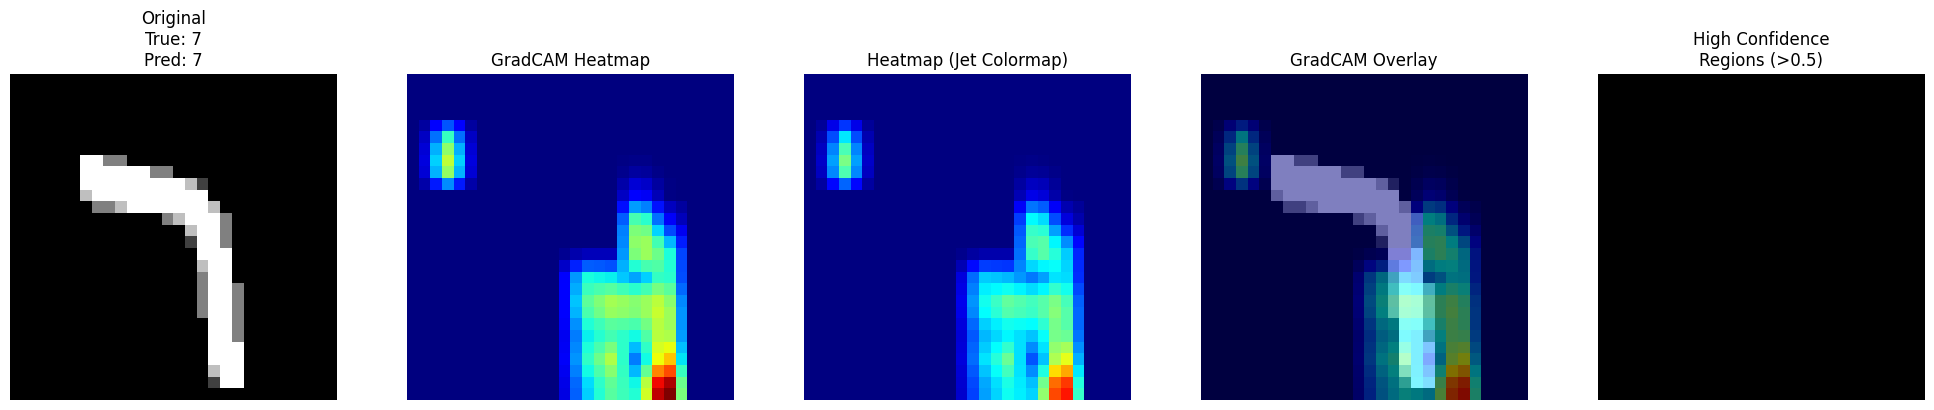

✓ Example 1: True=7, Predicted=7


In [11]:
# Find a good example - look for a correctly classified digit with clear features
test_iter = iter(test_loader)
for _ in range(20):  # Skip first 20 samples to get a different example
    image, true_label = next(test_iter)

# Generate GradCAM
cam, pred_label = gradcam.generate_cam(image, target_class=None)
img_normalized, cam_resized, heatmap, overlay = gradcam.visualize_cam(image, cam)

# Visualize
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

axes[0].imshow(img_normalized, cmap='gray')
axes[0].set_title(f'Original\nTrue: {true_label.item()}\nPred: {pred_label}')
axes[0].axis('off')

axes[1].imshow(cam_resized, cmap='jet')
axes[1].set_title('GradCAM Heatmap')
axes[1].axis('off')

axes[2].imshow(heatmap)
axes[2].set_title('Heatmap (Jet Colormap)')
axes[2].axis('off')

axes[3].imshow(overlay)
axes[3].set_title('GradCAM Overlay')
axes[3].axis('off')

# High confidence regions
high_conf_mask = cam_resized > 0.5
masked_img = img_normalized.copy()
masked_img[~high_conf_mask] = 0
axes[4].imshow(masked_img, cmap='gray')
axes[4].set_title('High Confidence\nRegions (>0.5)')
axes[4].axis('off')

plt.tight_layout()
plt.show()

print(f"✓ Example 1: True={true_label.item()}, Predicted={pred_label}")

### Example 2-5: Multiple Examples

/home/matthewcockayne/.local/lib/python3.10/site-packages/torch/nn/functional.py:1531: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


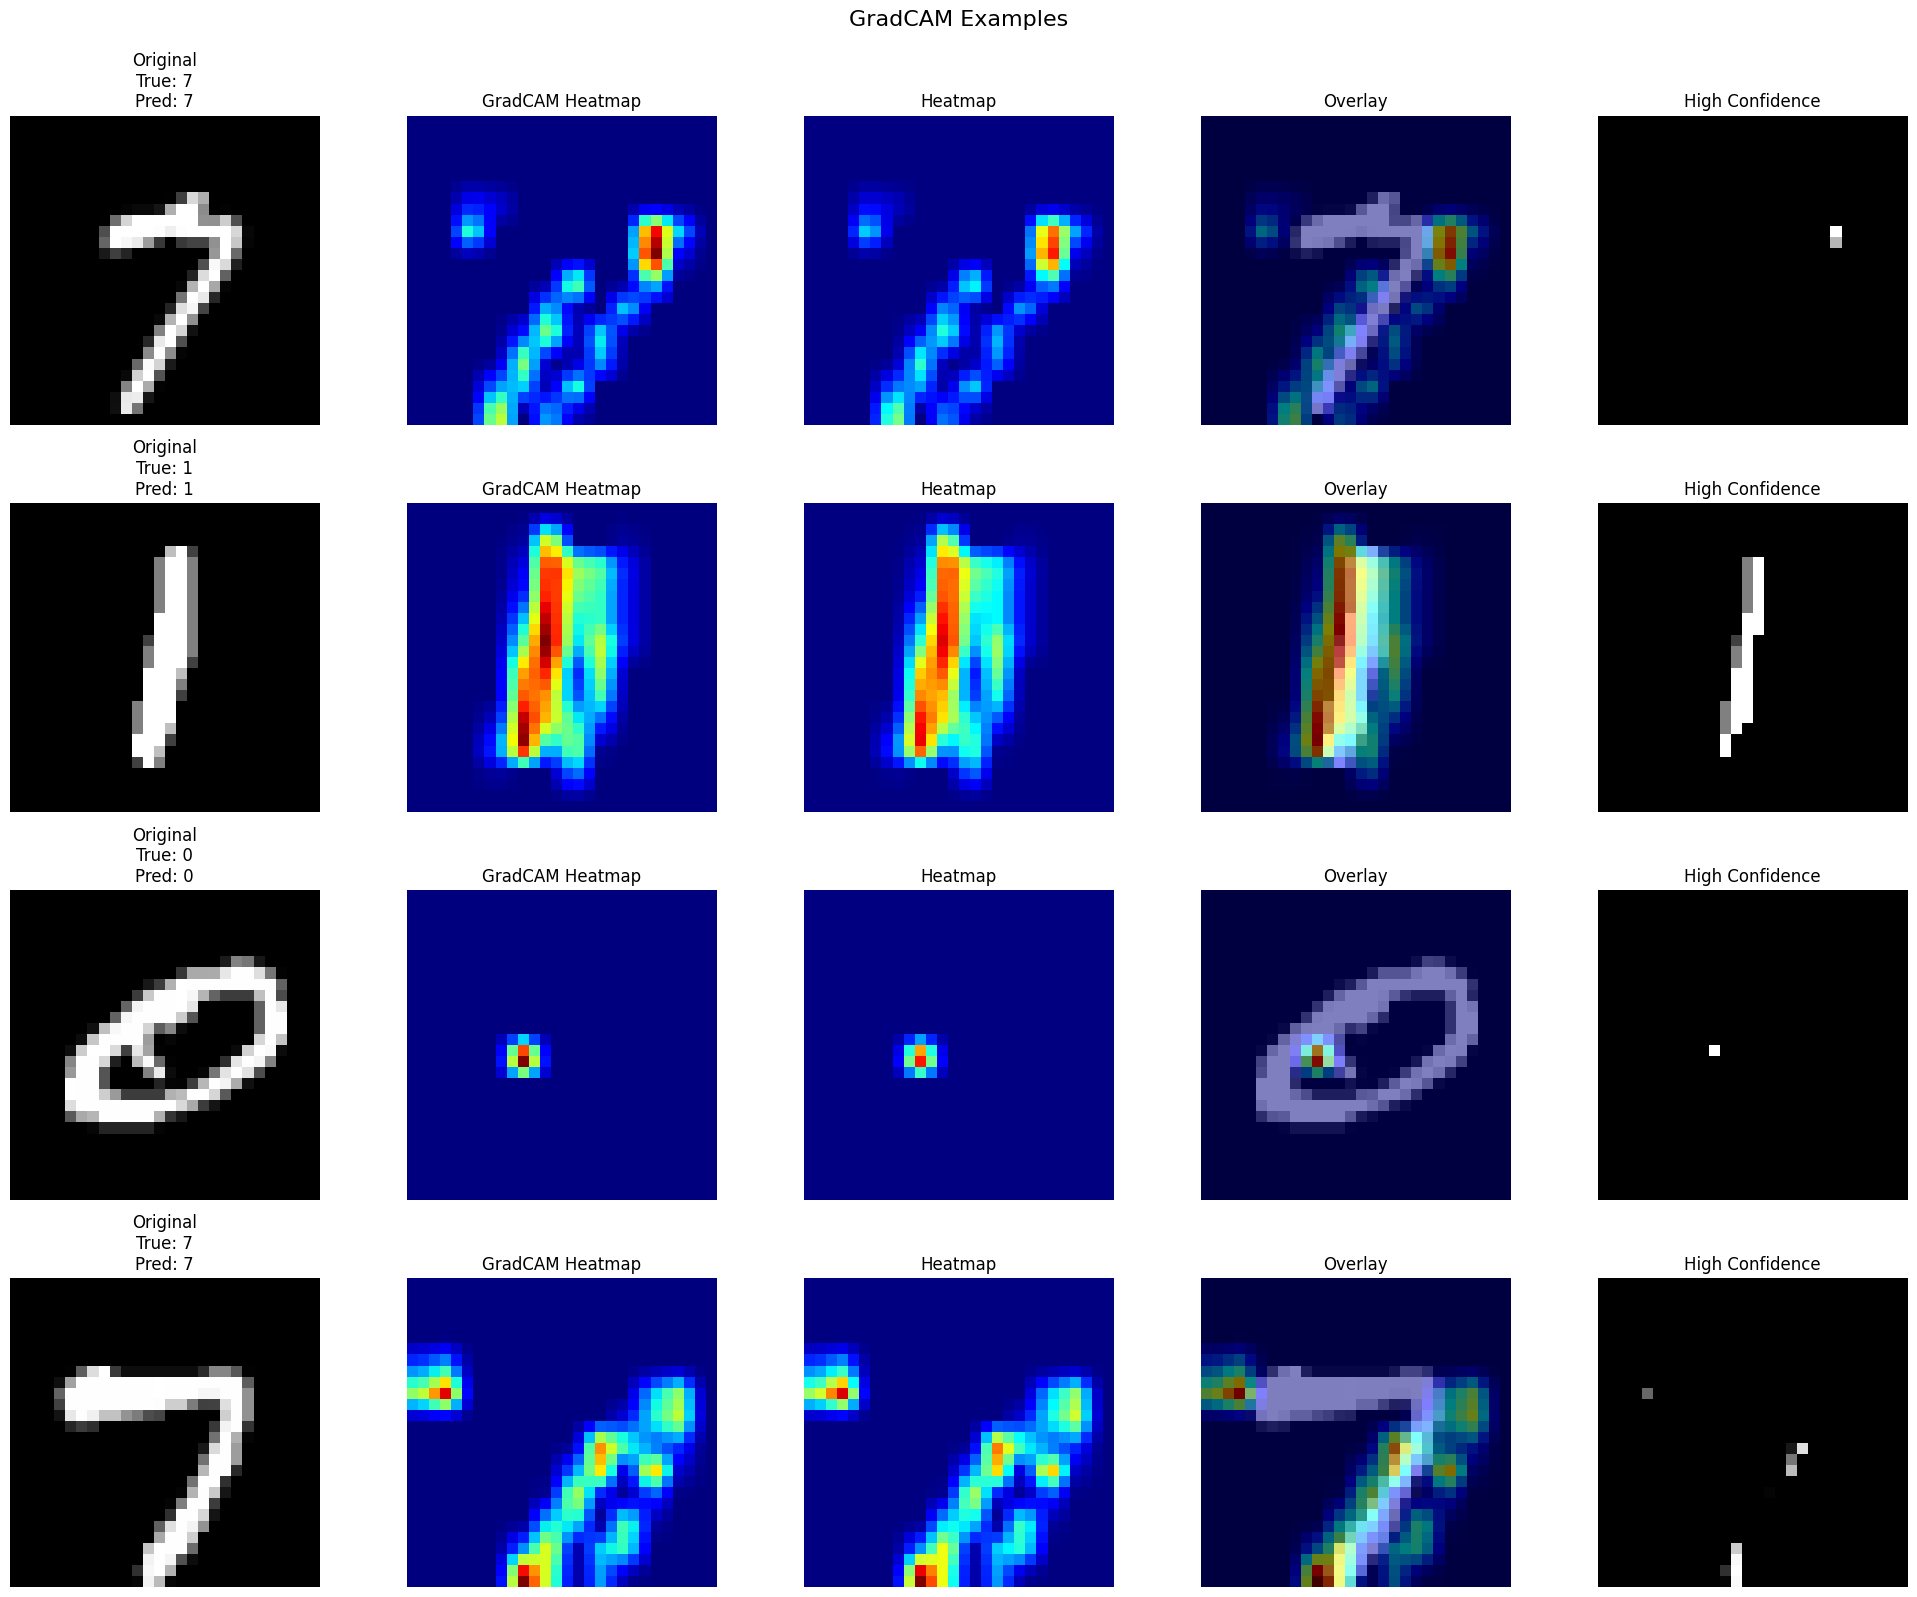

✓ Saved GradCAM examples


In [14]:
fig, axes = plt.subplots(4, 5, figsize=(20, 16))

for idx in range(4):
    for _ in range(20):  # Skip first 20 samples to get a different example
        image, true_label = next(test_iter)
    
    cam, pred_label = gradcam.generate_cam(image, target_class=None)
    img_normalized, cam_resized, heatmap, overlay = gradcam.visualize_cam(image, cam)
    
    axes[idx, 0].imshow(img_normalized, cmap='gray')
    axes[idx, 0].set_title(f'Original\nTrue: {true_label.item()}\nPred: {pred_label}')
    axes[idx, 0].axis('off')
    
    axes[idx, 1].imshow(cam_resized, cmap='jet')
    axes[idx, 1].set_title('GradCAM Heatmap')
    axes[idx, 1].axis('off')
    
    axes[idx, 2].imshow(heatmap)
    axes[idx, 2].set_title('Heatmap')
    axes[idx, 2].axis('off')
    
    axes[idx, 3].imshow(overlay)
    axes[idx, 3].set_title('Overlay')
    axes[idx, 3].axis('off')
    
    high_conf_mask = cam_resized > 0.5
    masked_img = img_normalized.copy()
    masked_img[~high_conf_mask] = 0
    axes[idx, 4].imshow(masked_img, cmap='gray')
    axes[idx, 4].set_title('High Confidence')
    axes[idx, 4].axis('off')

plt.suptitle('GradCAM Examples', fontsize=16, y=0.995)
plt.tight_layout()
plt.savefig(output_dir / 'gradcam_examples.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved GradCAM examples")

## 8. Correct vs Incorrect Predictions

Let's compare GradCAM for correct and incorrect predictions.

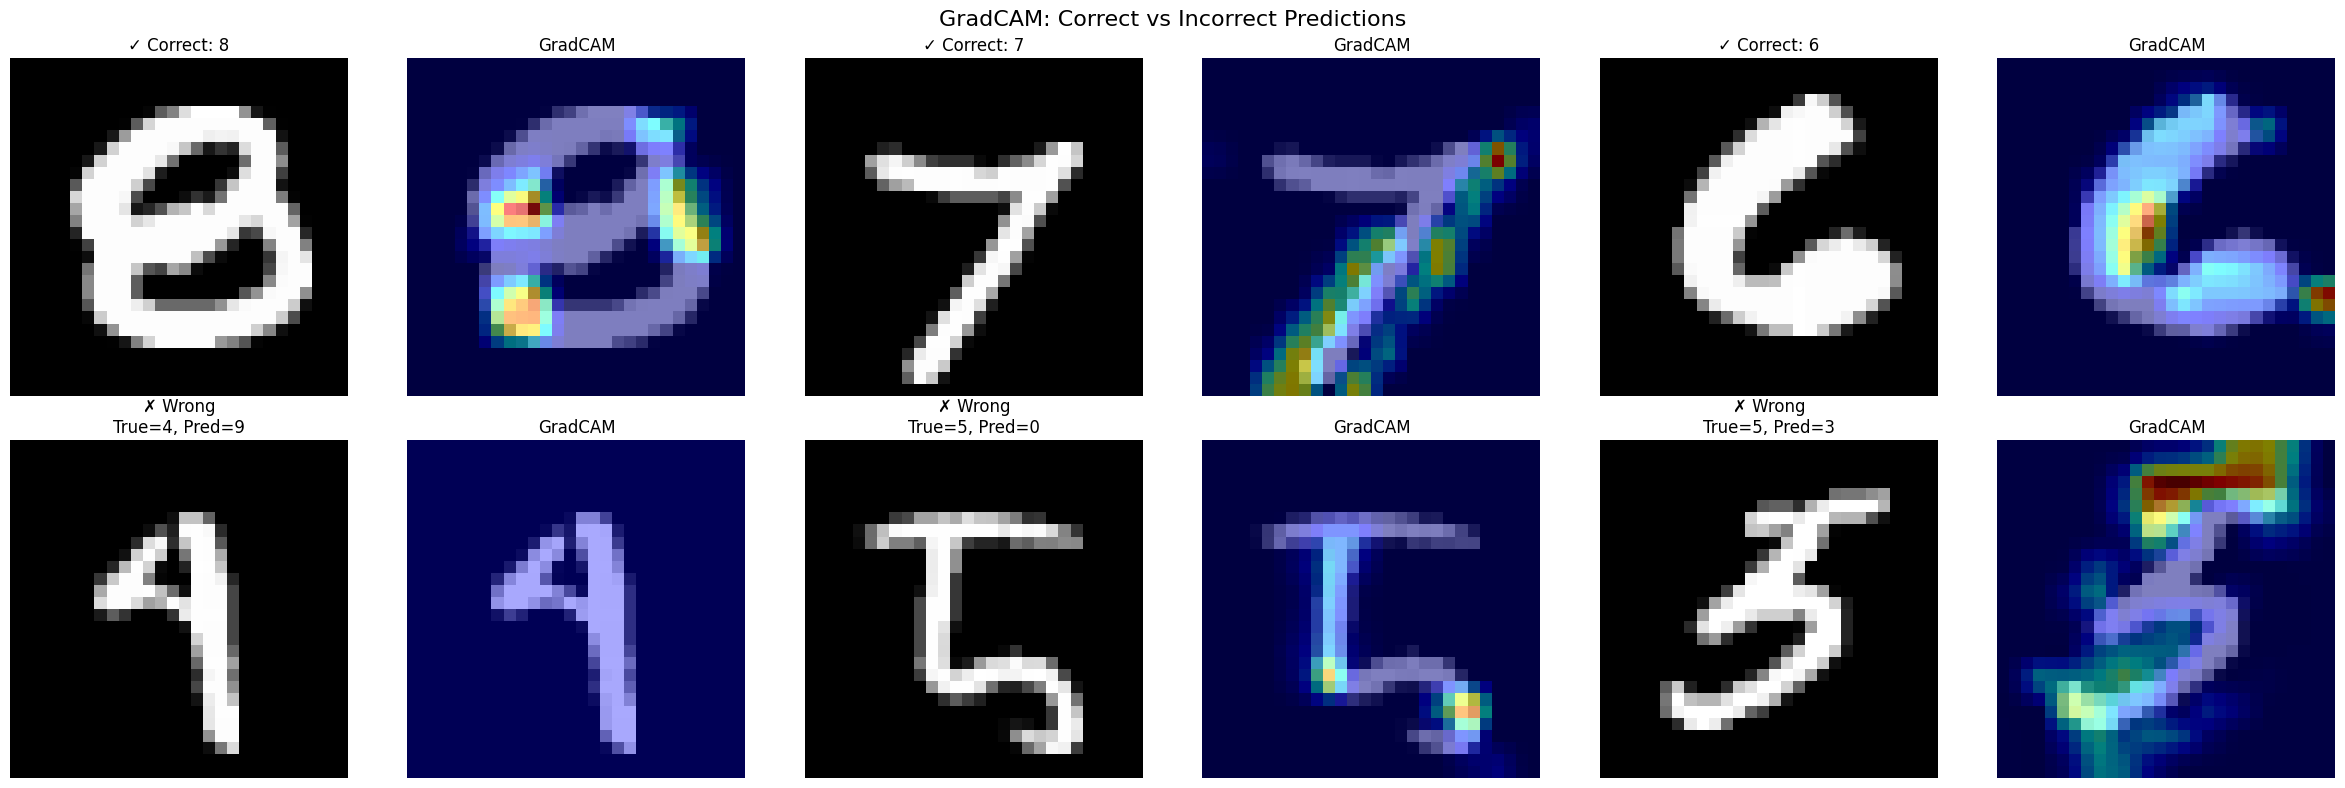

✓ Saved correct vs incorrect comparison


In [15]:
correct_examples = []
incorrect_examples = []

# Find examples
test_iter = iter(test_loader)
while len(correct_examples) < 3 or len(incorrect_examples) < 3:
    image, true_label = next(test_iter)
    
    with torch.no_grad():
        output = model(image.to(device))
        pred_label = output.argmax(dim=1).item()
    
    if pred_label == true_label.item() and len(correct_examples) < 3:
        correct_examples.append((image, true_label.item(), pred_label))
    elif pred_label != true_label.item() and len(incorrect_examples) < 3:
        incorrect_examples.append((image, true_label.item(), pred_label))

# Visualize
fig, axes = plt.subplots(2, 6, figsize=(24, 8))

# Correct predictions
for idx, (image, true_label, pred_label) in enumerate(correct_examples):
    cam, _ = gradcam.generate_cam(image, target_class=pred_label)
    img_normalized, _, _, overlay = gradcam.visualize_cam(image, cam)
    
    axes[0, idx*2].imshow(img_normalized, cmap='gray')
    axes[0, idx*2].set_title(f'✓ Correct: {pred_label}')
    axes[0, idx*2].axis('off')
    
    axes[0, idx*2+1].imshow(overlay)
    axes[0, idx*2+1].set_title('GradCAM')
    axes[0, idx*2+1].axis('off')

# Incorrect predictions
for idx, (image, true_label, pred_label) in enumerate(incorrect_examples):
    cam, _ = gradcam.generate_cam(image, target_class=pred_label)
    img_normalized, _, _, overlay = gradcam.visualize_cam(image, cam)
    
    axes[1, idx*2].imshow(img_normalized, cmap='gray')
    axes[1, idx*2].set_title(f'✗ Wrong\nTrue={true_label}, Pred={pred_label}')
    axes[1, idx*2].axis('off')
    
    axes[1, idx*2+1].imshow(overlay)
    axes[1, idx*2+1].set_title('GradCAM')
    axes[1, idx*2+1].axis('off')

fig.suptitle('GradCAM: Correct vs Incorrect Predictions', fontsize=16, y=0.98)
plt.tight_layout()
plt.savefig(output_dir / 'gradcam_correct_vs_incorrect.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved correct vs incorrect comparison")

## 9. Summary

### Key Takeaways:

1. **GradCAM highlights important image regions** using gradients
2. **Bright regions** = high importance for predicted class
3. **Fast**: Single forward + backward pass (~milliseconds)
4. **Works with any CNN** without retraining
5. **Class-discriminative**: Shows what model focuses on for specific class

### When to Use GradCAM:
- ✅ Quick visual explanations for CNNs
- ✅ Debugging model focus
- ✅ Real-time applications (very fast)
- ✅ Understanding failure modes
- ✅ Building trust in predictions

### Interpreting GradCAM:

**For Correct Predictions**:
- Model focuses on relevant features (e.g., digit strokes)
- High activation on discriminative regions

**For Incorrect Predictions**:
- May reveal model confusion
- Shows where model focused (even if wrong)
- Helps identify data quality issues

### Comparison with Other Methods:

| Aspect | GradCAM | LIME | SHAP |
|--------|---------|------|------|
| **Speed** | Very Fast (ms) | Slow (~30s) | Fast (GradExplainer) |
| **Theory** | Gradient-based | Linear approx. | Game theory |
| **Architecture** | CNN only | Any model | Any model |
| **Resolution** | Feature map size | Image size | Image size |
| **Model Access** | Needs internals | Black box | Needs gradients |

### Limitations:

1. **Resolution**: Limited by feature map size (low-res for deep layers)
2. **Only positive**: ReLU removes negative evidence
3. **CNN-specific**: Doesn't work with other architectures
4. **Single layer**: Uses only last conv layer

### Variants:

- **Grad-CAM++**: Better localization for multiple objects
- **Score-CAM**: Gradient-free (more stable)
- **XGrad-CAM**: Weighted gradients
- **Layer-CAM**: Per-layer explanations

### Best Practices:

1. **Target layer selection**: Use last convolutional layer
2. **Colormap**: Jet or hot colormaps work well
3. **Overlay alpha**: 0.5-0.7 for good visibility
4. **Threshold**: Use >0.5 for high-confidence regions
5. **Compare methods**: Use multiple XAI techniques for robustness

### Next Steps:
- Try Grad-CAM++ for better localization
- Combine with LIME or SHAP for comprehensive analysis
- Apply to real-world medical imaging tasks
- Evaluate using faithfulness metrics

---

**All visualizations saved to**: `./results/gradcam/`